# Model Analysis
File to test and tune models

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import json
import lightgbm as lgb
import xgboost as xgb

## Pre-requisites 
Loading data and declaring functions for visualising model perfrmance 

In [13]:

class_names = ["Benign", "Malignant", "Normal"]

In [5]:
# Data Loading
def load_pca_data(split_dir):
    X = np.load(os.path.join(split_dir, 'X_pca.npy'))
    y = np.load(os.path.join(split_dir, 'y.npy'))
    return X, y

def load_config(config_path):
    """
    Load config parameters (data paths, etc.) from JSON file.
    Args:
        config_path (str): Where to read config file.
    Returns:
        config (dict): Dictionary of config parameters.
    """
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

In [6]:
# Data Loading
def load_data(split_dir):
    X = np.load(os.path.join(split_dir, 'X.npy'))
    y = np.load(os.path.join(split_dir, 'y.npy'))
    return X, y

def load_config(config_path):
    """
    Load config parameters (data paths, etc.) from JSON file.
    Args:
        config_path (str): Where to read config file.
    Returns:
        config (dict): Dictionary of config parameters.
    """
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

In [7]:
config = load_config("../config.json")
data_root = config["processed_data_dir"]
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
test_dir = os.path.join(data_root, 'test')

X_train, y_train = load_pca_data(train_dir)
X_val, y_val = load_pca_data(val_dir)
X_test, y_test = load_pca_data(test_dir)

In [9]:
def evaluate_model(clf, X, y, set_name="Validation"):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1] if len(clf.classes_) == 2 else clf.predict_proba(X)
    acc = accuracy_score(y, y_pred)
    print(f"{set_name} Accuracy: {acc:.3f}")
    print(f"{set_name} Classification Report:\n", classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return y_pred, y_prob

In [10]:
def plot_roc_curve(y, y_prob, set_name="Validation"):
    if len(np.unique(y)) == 2:
        fpr, tpr, thresholds = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{set_name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
        print(f"{set_name} ROC AUC: {roc_auc:.3f}")

In [11]:
def plot_precision_recall(y_true, y_scores, class_names=None):
    """
    Plots precision-recall curves for each class.
    Args:
        y_true (array-like): True labels (N,)
        y_scores (array-like): Shape (N, n_classes) predicted probabilities
        class_names (list): List of class names for legend
    """
    n_classes = y_scores.shape[1]
    plt.figure()
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_scores[:, i])
        ap = average_precision_score((y_true == i).astype(int), y_scores[:, i])
        label = f"Class {i}" if class_names is None else class_names[i]
        plt.plot(recall, precision, lw=2, label=f'{label} (AP={ap:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

## PCA Data 
### Logistic Regression

In [8]:
def train_logistic_regression(X_train, y_train):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    return clf

Validation Results:
Validation Accuracy: 0.909
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86        66
           1       0.83      0.91      0.87        66
           2       1.00      1.00      1.00        65

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



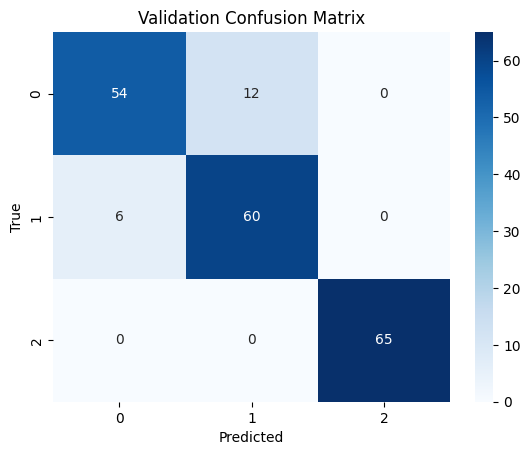

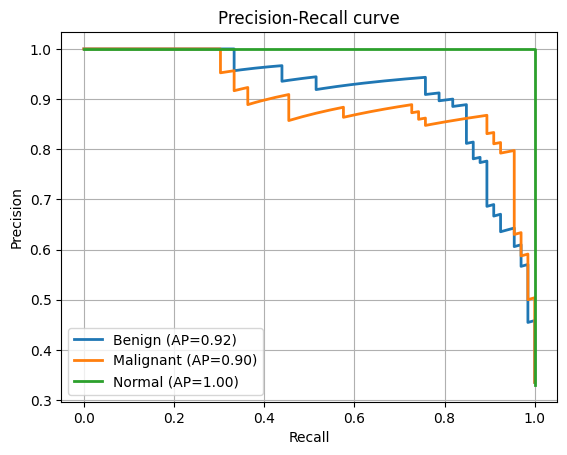

Test Results:
Test Accuracy: 0.873
Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83        65
           1       0.80      0.83      0.81        66
           2       0.97      0.98      0.98        66

    accuracy                           0.87       197
   macro avg       0.87      0.87      0.87       197
weighted avg       0.87      0.87      0.87       197



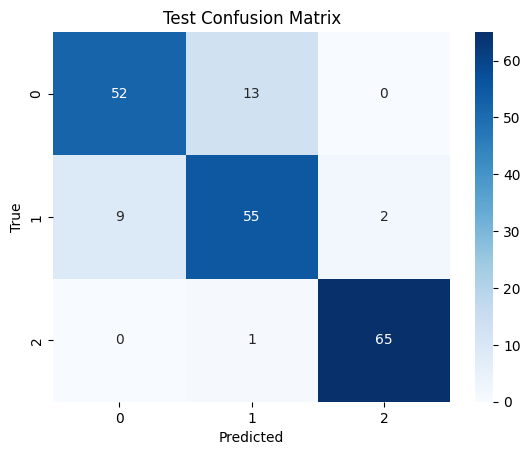

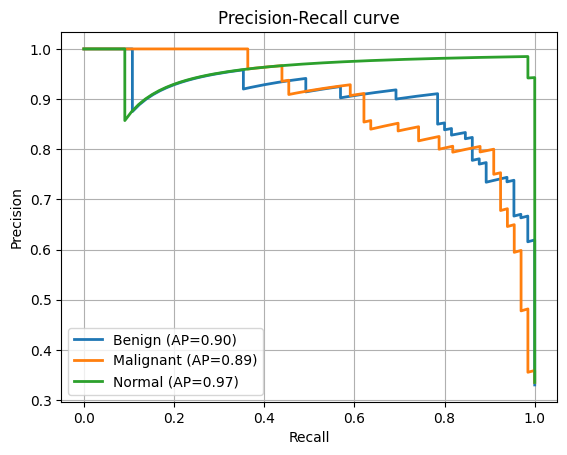

In [ ]:

clf = train_logistic_regression(X_train, y_train)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)


### k Nearest Neighbour

In [2]:
def train_knn_weighted(X_train, y_train, k=5):
    # Use weights="distance" so nearer neighbors count more
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    return knn

k=1, Cross-Validation Error: 0.1233
k=2, Cross-Validation Error: 0.1396
k=3, Cross-Validation Error: 0.1461
k=4, Cross-Validation Error: 0.1473
k=5, Cross-Validation Error: 0.1450
k=6, Cross-Validation Error: 0.1516
k=7, Cross-Validation Error: 0.1625
k=8, Cross-Validation Error: 0.1658
k=9, Cross-Validation Error: 0.1756
k=10, Cross-Validation Error: 0.1756
k=11, Cross-Validation Error: 0.1788
k=12, Cross-Validation Error: 0.1745
k=13, Cross-Validation Error: 0.1810
k=14, Cross-Validation Error: 0.1745
k=15, Cross-Validation Error: 0.1821
k=16, Cross-Validation Error: 0.1810
k=17, Cross-Validation Error: 0.1941
k=18, Cross-Validation Error: 0.1908
k=19, Cross-Validation Error: 0.1984
k=20, Cross-Validation Error: 0.1984
Best k found: 1 with error 0.1233


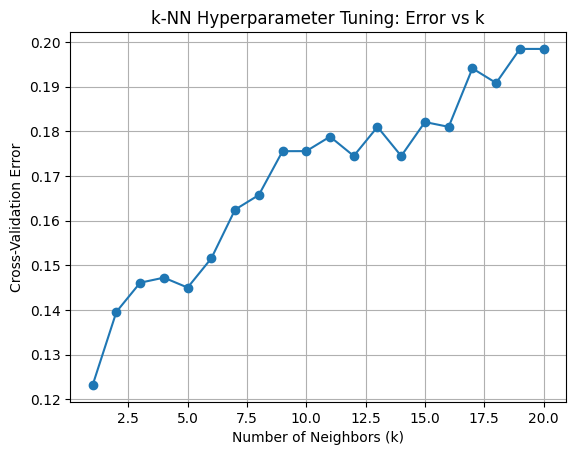

In [11]:
def knn_cross_validation(X_train, y_train, k_range=range(1, 21), cv=5):
    """
    Performs k-fold cross-validation to find the best k in k-NN
    Args:
        X_train (ndarray): Training features
        y_train (ndarray): Training labels
        k_range (iterable): Values of k to evaluate
        cv (int): Number of cross-validation folds
    Returns:
        best_k (int): Value of k with lowest error
        validation_errors (list): Average error for each k
    """
    validation_errors = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        # Use cross_val_score with accuracy scoring
        scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')
        avg_error = 1 - scores.mean()  # error = 1 - accuracy
        validation_errors.append(avg_error)
        print(f"k={k}, Cross-Validation Error: {avg_error:.4f}")

    best_k = k_range[np.argmin(validation_errors)]
    print(f"Best k found: {best_k} with error {min(validation_errors):.4f}")

    # Plot error curve
    plt.figure()
    plt.plot(k_range, validation_errors, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Cross-Validation Error')
    plt.title('k-NN Hyperparameter Tuning: Error vs k')
    plt.grid(True)
    plt.show()

    return best_k, validation_errors


best_k, errors = knn_cross_validation(X_train, y_train, k_range=range(1,21), cv=5)


Validation Results:
Validation Accuracy: 0.904
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85        66
           1       0.81      0.92      0.87        66
           2       1.00      0.98      0.99        65

    accuracy                           0.90       197
   macro avg       0.91      0.90      0.90       197
weighted avg       0.91      0.90      0.90       197



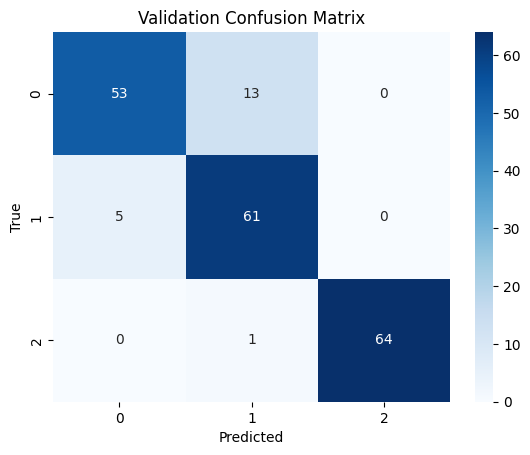

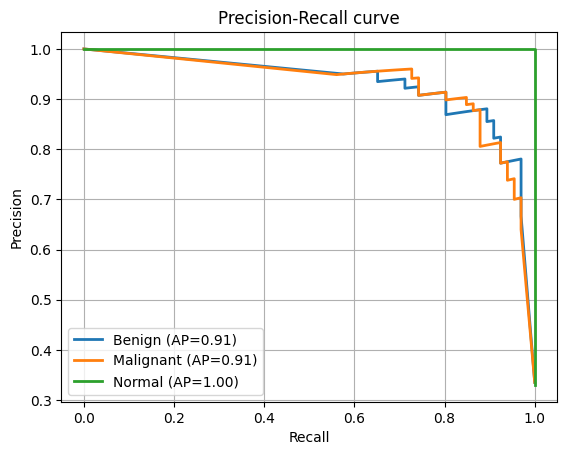

Test Results:
Test Accuracy: 0.888
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84        65
           1       0.80      0.91      0.85        66
           2       0.96      0.98      0.97        66

    accuracy                           0.89       197
   macro avg       0.89      0.89      0.89       197
weighted avg       0.89      0.89      0.89       197



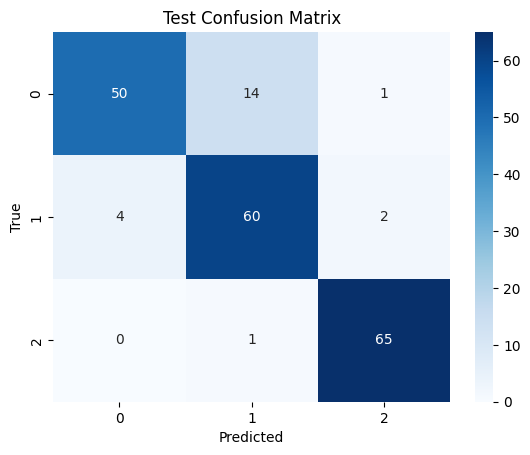

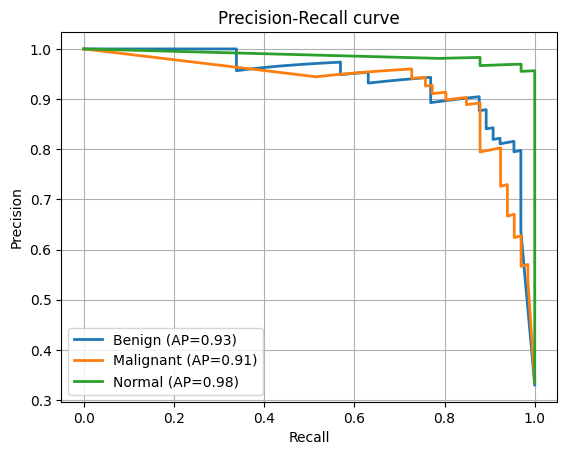

In [14]:
#Initilsie k
k = 5

knn_clf = train_knn_weighted(X_train, y_train, k=k)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(knn_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(knn_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

### Support Vector Machine

In [13]:
def train_svm(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    """
    Trains SVM with specified kernel and hyperparameters.
    multiclass is handled by one-vs-one automatically by scikit-learn's SVC.
    """
    svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    return svm

Validation Results:
Validation Accuracy: 0.939
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91        66
           1       0.91      0.92      0.92        66
           2       0.98      1.00      0.99        65

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



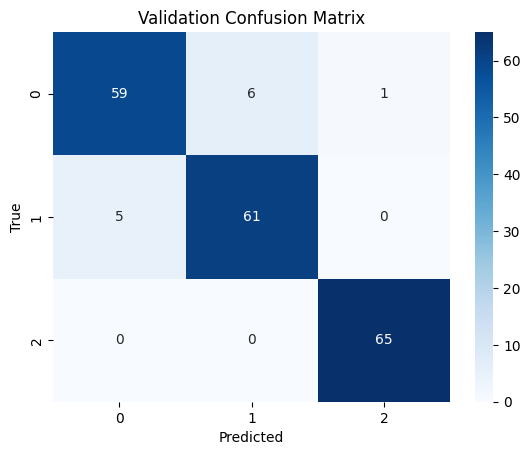

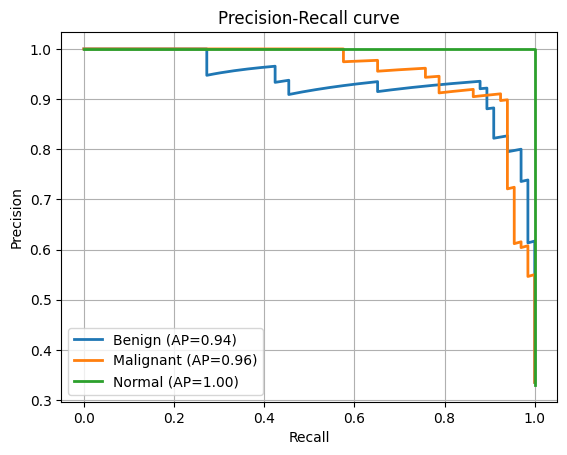

Test Results:
Test Accuracy: 0.914
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88        65
           1       0.84      0.92      0.88        66
           2       0.97      1.00      0.99        66

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



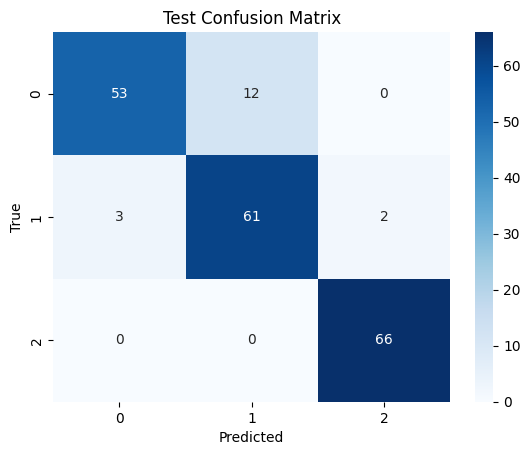

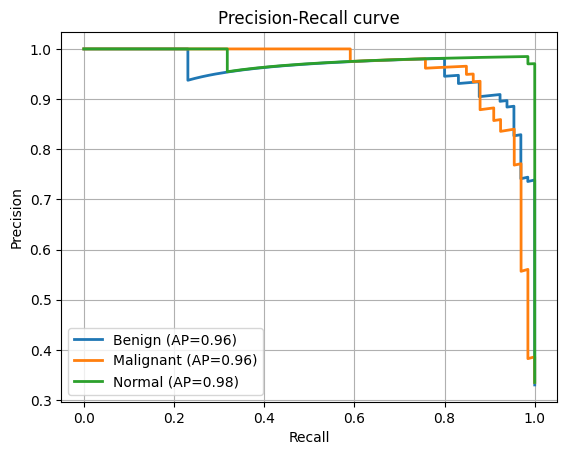

In [14]:
svm_clf = train_svm(X_train, y_train, kernel='rbf', C=1, gamma='scale')

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(svm_clf, X_val, y_val, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names=["Benign", "Malignant", "Normal"])

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(svm_clf, X_test, y_test, "Test")
plot_precision_recall(y_test, y_test_prob, class_names=["Benign", "Malignant", "Normal"])


### LightGBM

In [35]:
def train_lightGBM(X_train, y_train, X_val=X_val, y_val=y_val):
    lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_estimators=100)
    lgb_clf.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(20)],
    )

    return lgb_clf


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 917, number of used features: 150
[LightGBM] [Info] Start training from score -1.097522
[LightGBM] [Info] Start training from score -1.100796
[LightGBM] [Info] Start training from score -1.097522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.194337
Validation Results:
Validation Accuracy: 0.919
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88        6

/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


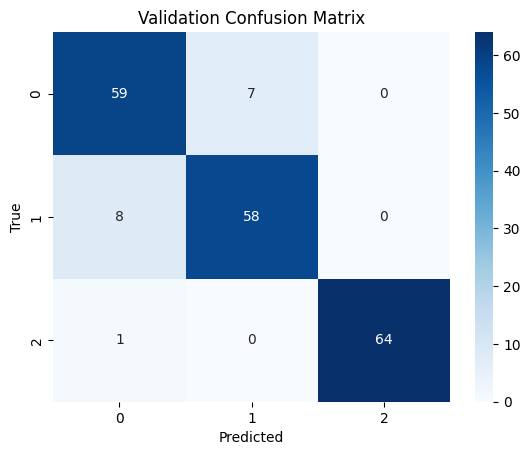

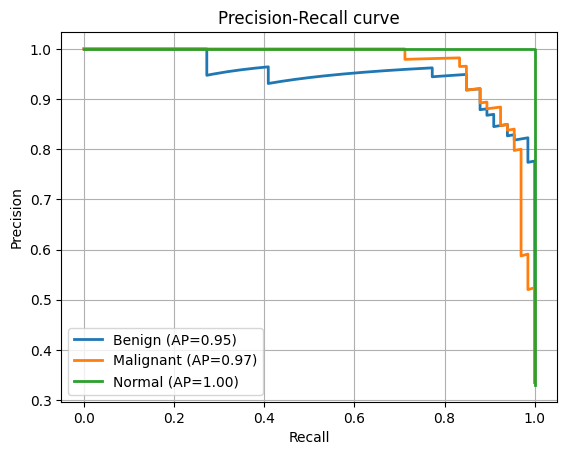

Test Results:
Test Accuracy: 0.919
Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        65
           1       0.89      0.89      0.89        66
           2       0.94      1.00      0.97        66

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197



/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


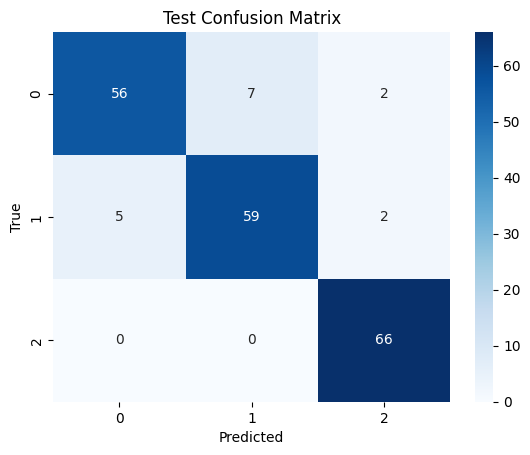

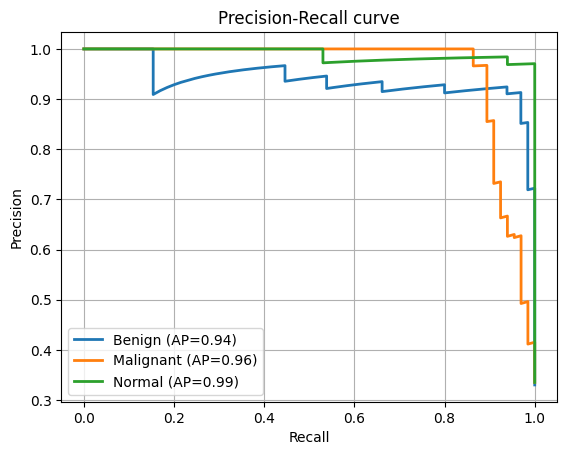

In [ ]:
lgb_clf = train_lightGBM(X_train, y_train)
print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(lgb_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(lgb_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

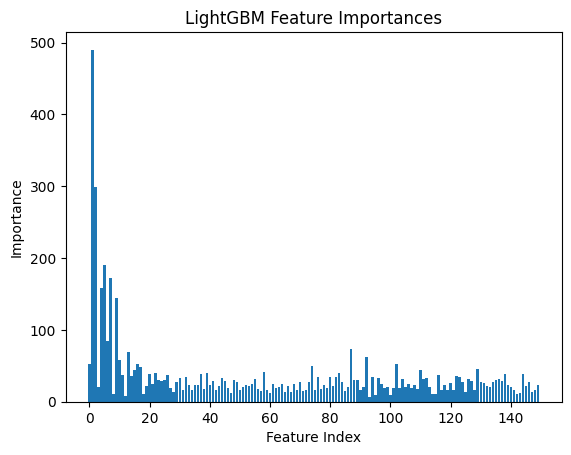

In [37]:
# Feature importances
plt.bar(np.arange(X_train.shape[1]), lgb_clf.feature_importances_)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('LightGBM Feature Importances')
plt.show()

### XGBoost

In [52]:
def train_XGBoost(X_train, y_train, X_val=X_val, y_val=y_val):
    # Initialize model
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        random_state=42,
        n_estimators=100,
        eval_metric='mlogloss',
        early_stopping_rounds=20
    )

    xgb_clf.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )

    return xgb_clf

[0]	validation_0-mlogloss:0.80534
[1]	validation_0-mlogloss:0.63842
[2]	validation_0-mlogloss:0.52094
[3]	validation_0-mlogloss:0.44998
[4]	validation_0-mlogloss:0.40167
[5]	validation_0-mlogloss:0.36055
[6]	validation_0-mlogloss:0.32559
[7]	validation_0-mlogloss:0.29879
[8]	validation_0-mlogloss:0.28625
[9]	validation_0-mlogloss:0.26691
[10]	validation_0-mlogloss:0.25556
[11]	validation_0-mlogloss:0.24675
[12]	validation_0-mlogloss:0.24522
[13]	validation_0-mlogloss:0.24838
[14]	validation_0-mlogloss:0.24755
[15]	validation_0-mlogloss:0.24815
[16]	validation_0-mlogloss:0.24709
[17]	validation_0-mlogloss:0.24630
[18]	validation_0-mlogloss:0.24760
[19]	validation_0-mlogloss:0.25250
[20]	validation_0-mlogloss:0.25310
[21]	validation_0-mlogloss:0.25338
[22]	validation_0-mlogloss:0.25225
[23]	validation_0-mlogloss:0.25503
[24]	validation_0-mlogloss:0.25798
[25]	validation_0-mlogloss:0.25914
[26]	validation_0-mlogloss:0.26078
[27]	validation_0-mlogloss:0.26065
[28]	validation_0-mlogloss:0.2

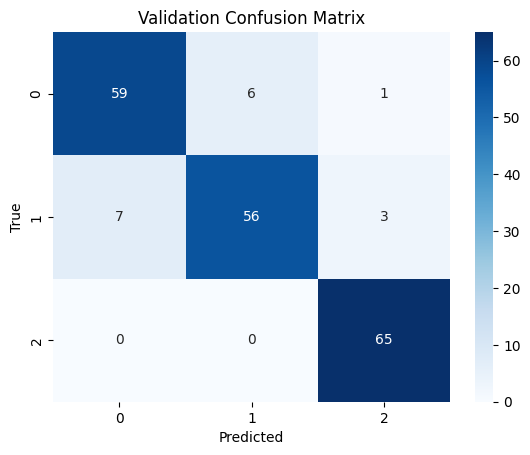

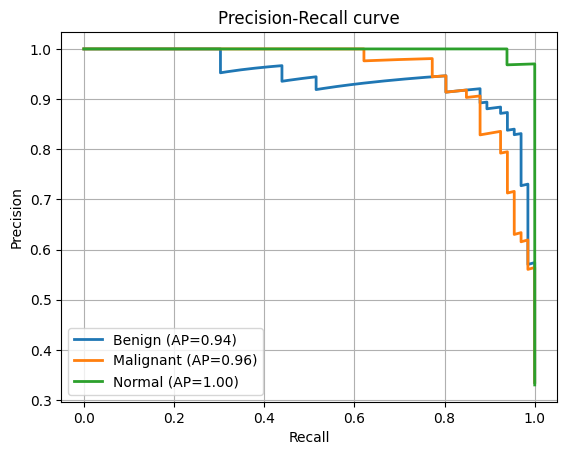

Test Results:
Test Accuracy: 0.893
Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87        65
           1       0.86      0.85      0.85        66
           2       0.93      0.98      0.96        66

    accuracy                           0.89       197
   macro avg       0.89      0.89      0.89       197
weighted avg       0.89      0.89      0.89       197



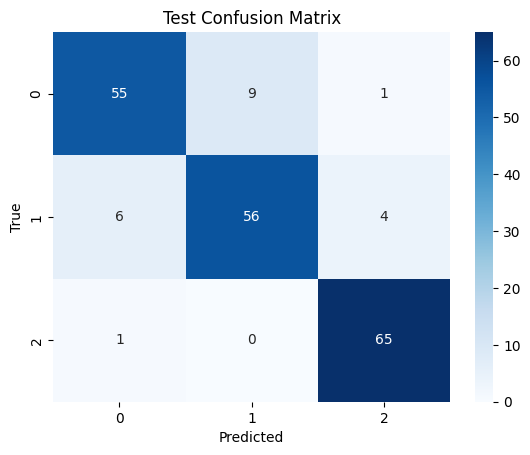

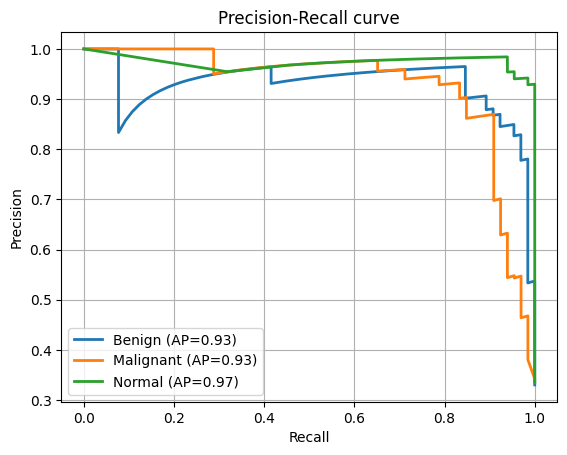

In [53]:
xgb_clf = train_XGBoost(X_train, y_train)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(xgb_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(xgb_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)



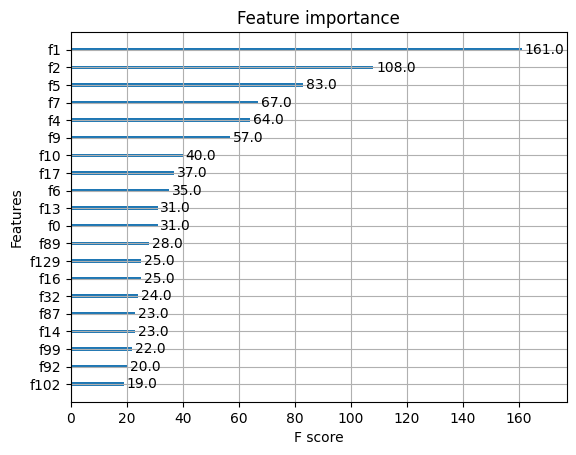

In [42]:
# Feature importances
xgb.plot_importance(xgb_clf, max_num_features=20)
plt.show()

## No PCA

In [43]:
config = load_config("../config.json")
data_root = config["processed_data_dir"]
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
test_dir = os.path.join(data_root, 'test')

X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

### Logistic Regression

Validation Results:
Validation Accuracy: 0.929
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89        66
           1       0.85      0.97      0.91        66
           2       0.98      0.98      0.98        65

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



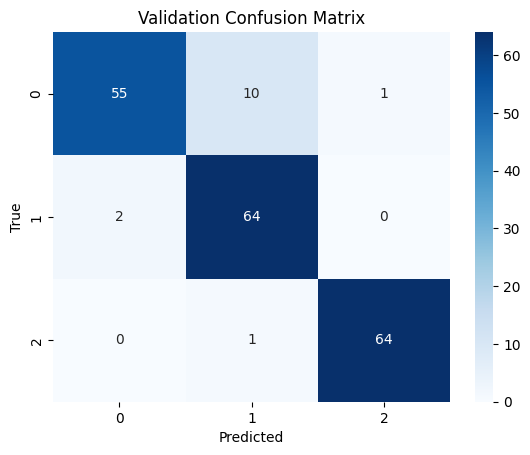

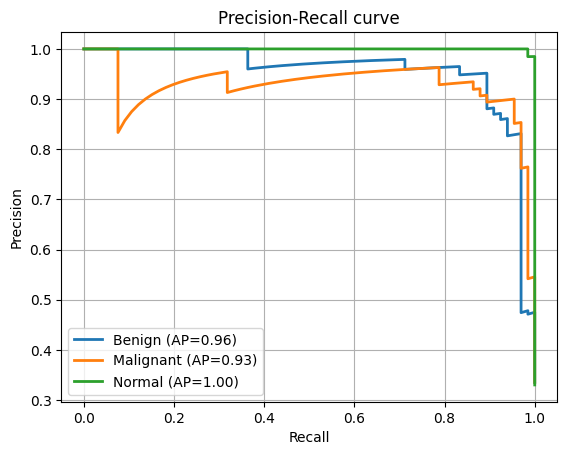

Test Results:
Test Accuracy: 0.919
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        65
           1       0.86      0.91      0.88        66
           2       0.97      1.00      0.99        66

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197



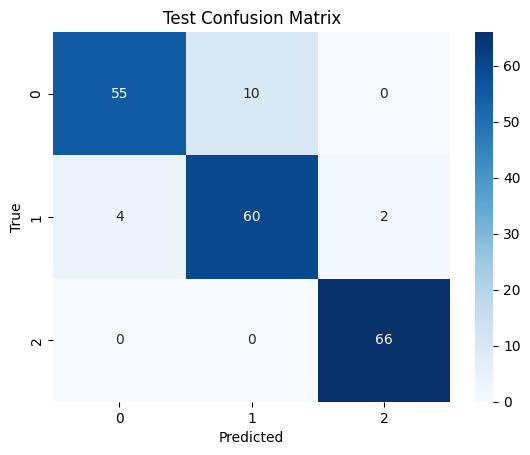

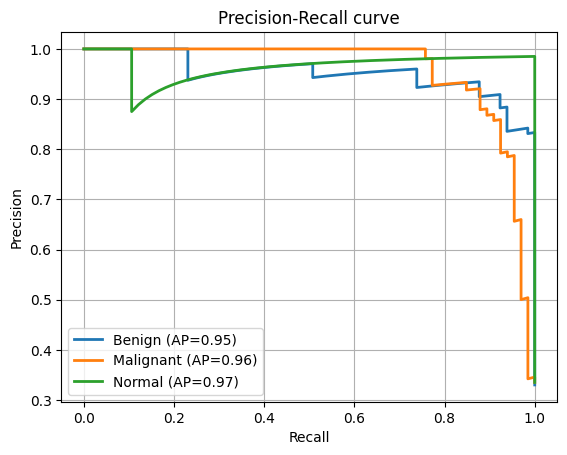

In [44]:

class_names = ["Benign", "Malignant", "Normal"]
clf = train_logistic_regression(X_train, y_train)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)


### kNN

Validation Results:
Validation Accuracy: 0.909
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.87        66
           1       0.83      0.91      0.87        66
           2       1.00      0.98      0.99        65

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



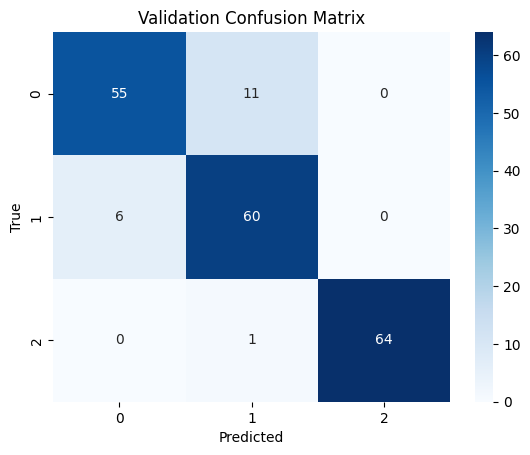

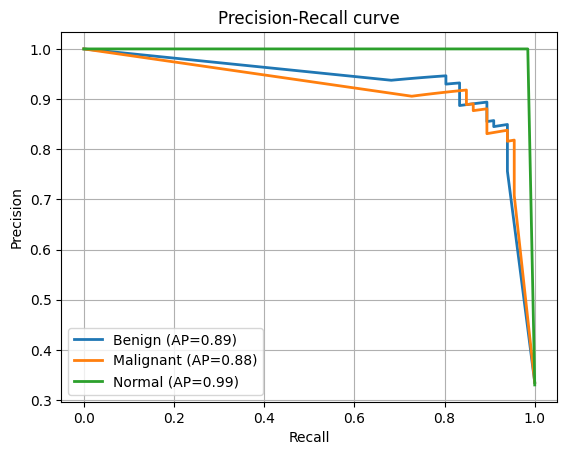

Test Results:
Test Accuracy: 0.893
Test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86        65
           1       0.82      0.89      0.86        66
           2       0.96      0.97      0.96        66

    accuracy                           0.89       197
   macro avg       0.90      0.89      0.89       197
weighted avg       0.90      0.89      0.89       197



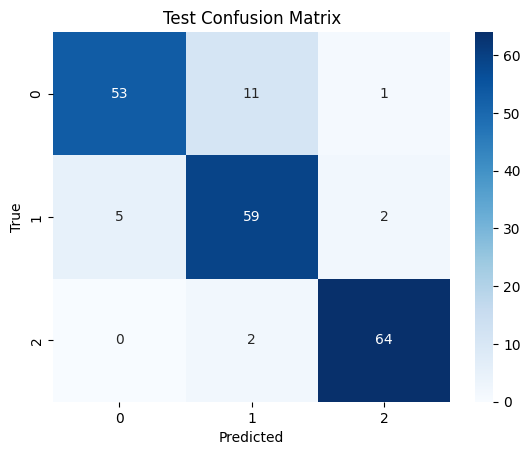

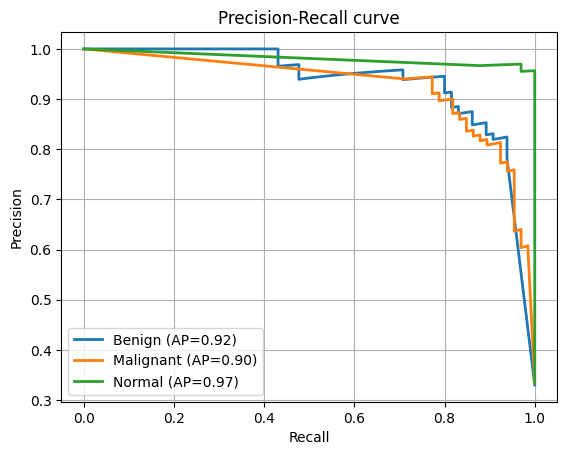

In [20]:
#Initilsie k
k = 3

knn_clf = train_knn_weighted(X_train, y_train, k=k)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(knn_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(knn_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

### SVM

Validation Results:
Validation Accuracy: 0.929
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89        66
           1       0.90      0.91      0.90        66
           2       0.98      1.00      0.99        65

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



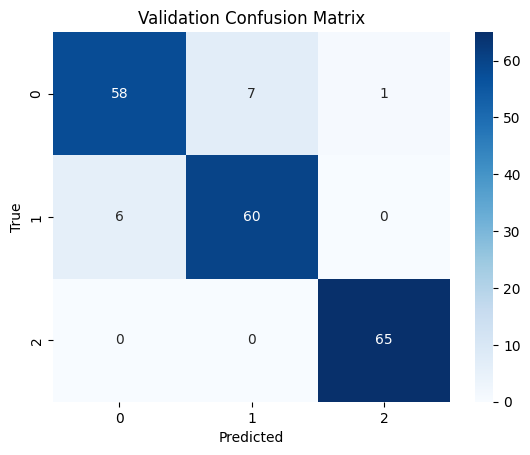

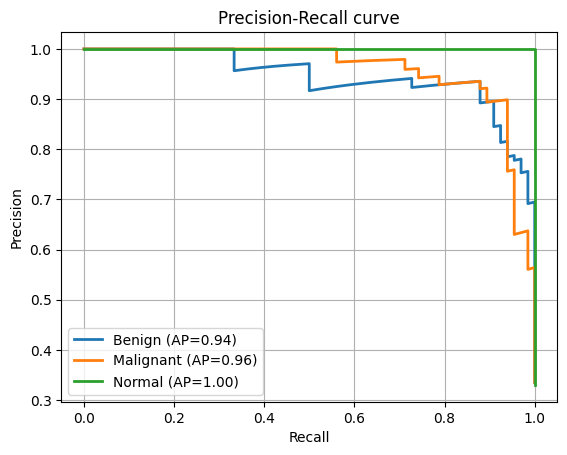

Test Results:
Test Accuracy: 0.924
Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89        65
           1       0.84      0.95      0.89        66
           2       0.97      1.00      0.99        66

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197



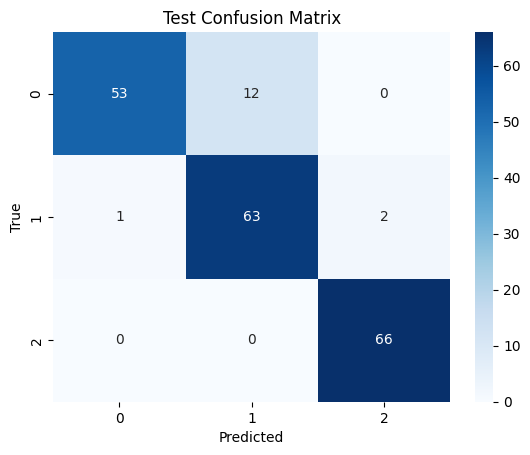

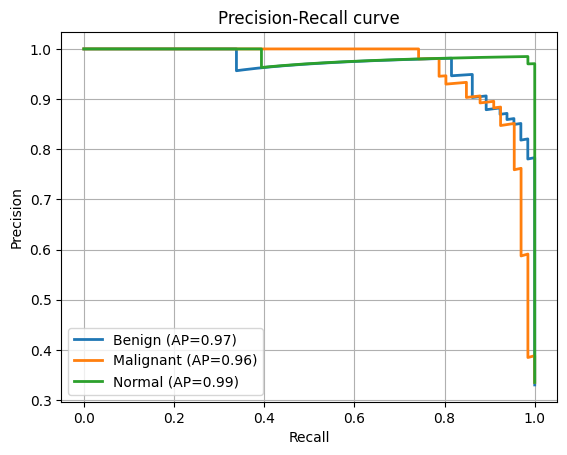

In [45]:
svm_clf = train_svm(X_train, y_train, kernel='rbf', C=1, gamma='scale')

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(svm_clf, X_val, y_val, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names=["Benign", "Malignant", "Normal"])

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(svm_clf, X_test, y_test, "Test")
plot_precision_recall(y_test, y_test_prob, class_names=["Benign", "Malignant", "Normal"])


### LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4162242
[LightGBM] [Info] Number of data points in the train set: 917, number of used features: 16388
[LightGBM] [Info] Start training from score -1.097522
[LightGBM] [Info] Start training from score -1.100796
[LightGBM] [Info] Start training from score -1.097522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10297
Validation Results:
Validation Accuracy: 0.838
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       

/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


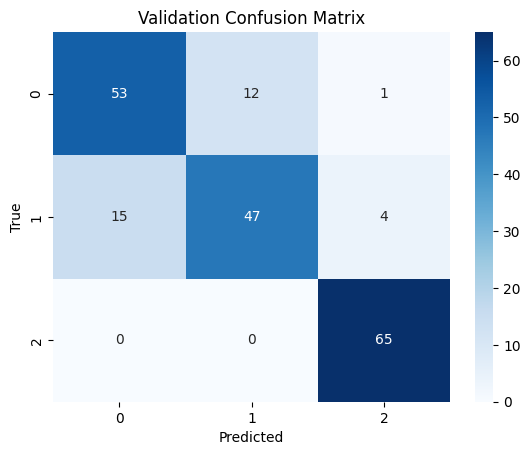

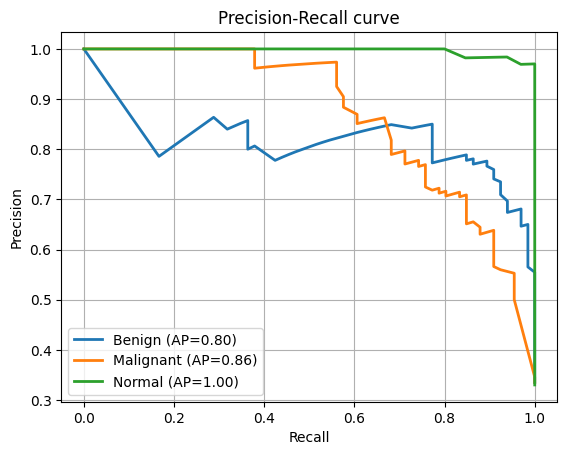

Test Results:
Test Accuracy: 0.822
Test Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74        65
           1       0.76      0.79      0.78        66
           2       0.94      0.95      0.95        66

    accuracy                           0.82       197
   macro avg       0.82      0.82      0.82       197
weighted avg       0.82      0.82      0.82       197



/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


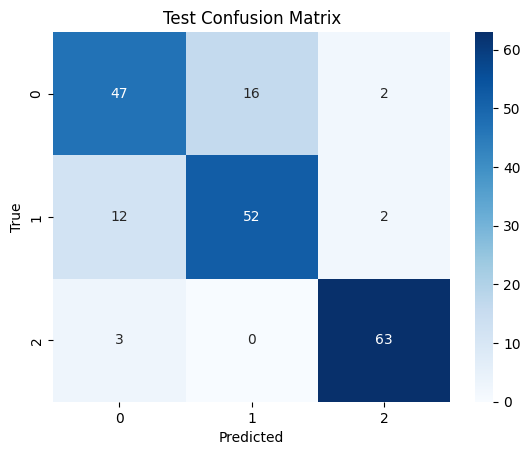

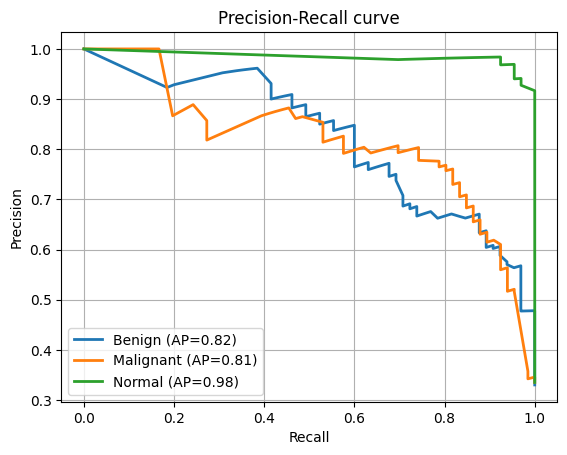

In [46]:
lgb_clf = train_lightGBM(X_train, y_train)
print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(lgb_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(lgb_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

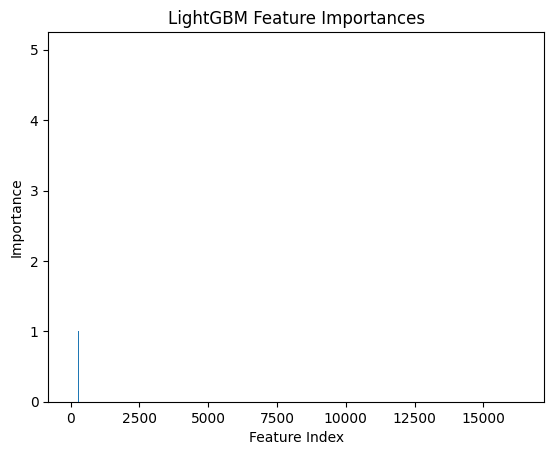

In [47]:
# Feature importances
plt.bar(np.arange(X_train.shape[1]), lgb_clf.feature_importances_)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('LightGBM Feature Importances')
plt.show()

### XGBoost

[0]	validation_0-mlogloss:0.80534
[1]	validation_0-mlogloss:0.63842
[2]	validation_0-mlogloss:0.52094
[3]	validation_0-mlogloss:0.44998
[4]	validation_0-mlogloss:0.40167
[5]	validation_0-mlogloss:0.36055
[6]	validation_0-mlogloss:0.32559
[7]	validation_0-mlogloss:0.29879
[8]	validation_0-mlogloss:0.28625
[9]	validation_0-mlogloss:0.26691
[10]	validation_0-mlogloss:0.25556
[11]	validation_0-mlogloss:0.24675
[12]	validation_0-mlogloss:0.24522
[13]	validation_0-mlogloss:0.24838
[14]	validation_0-mlogloss:0.24755
[15]	validation_0-mlogloss:0.24815
[16]	validation_0-mlogloss:0.24709
[17]	validation_0-mlogloss:0.24630
[18]	validation_0-mlogloss:0.24760
[19]	validation_0-mlogloss:0.25250
[20]	validation_0-mlogloss:0.25310
[21]	validation_0-mlogloss:0.25338
[22]	validation_0-mlogloss:0.25225
[23]	validation_0-mlogloss:0.25503
[24]	validation_0-mlogloss:0.25798
[25]	validation_0-mlogloss:0.25914
[26]	validation_0-mlogloss:0.26078
[27]	validation_0-mlogloss:0.26065
[28]	validation_0-mlogloss:0.2

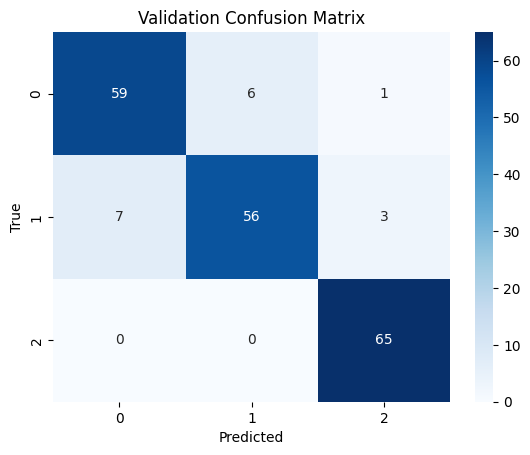

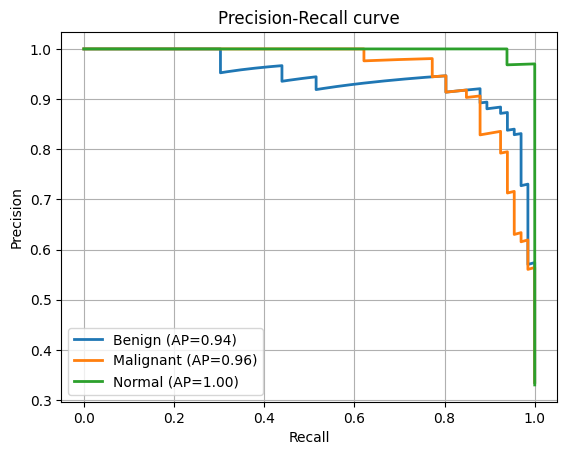

Test Results:
Test Accuracy: 0.893
Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87        65
           1       0.86      0.85      0.85        66
           2       0.93      0.98      0.96        66

    accuracy                           0.89       197
   macro avg       0.89      0.89      0.89       197
weighted avg       0.89      0.89      0.89       197



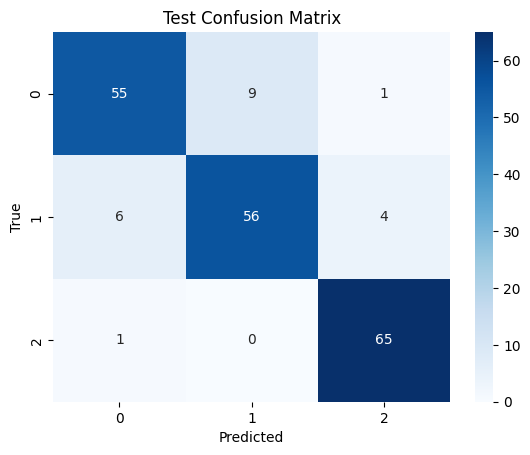

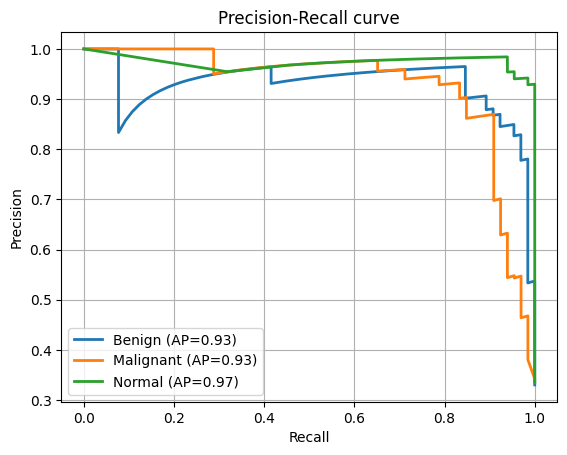

In [54]:
xgb_clf = train_XGBoost(X_train, y_train)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(xgb_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(xgb_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

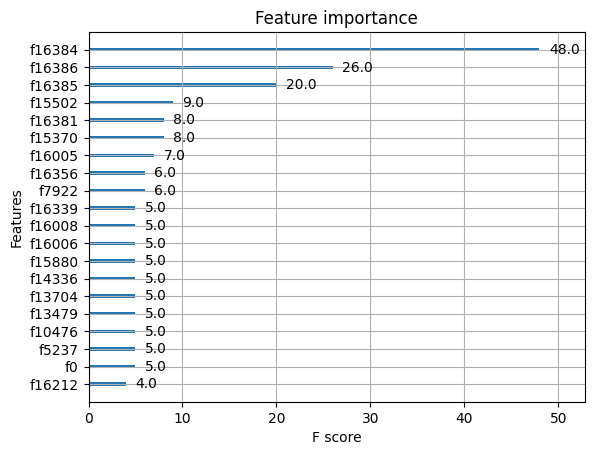

In [55]:
# Feature importances
xgb.plot_importance(xgb_clf, max_num_features=20)
plt.show()